# Get multiplets for different signalness thresholds

In [9]:

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from utils import get_multiplet_index_dictionary, go_through_area_multiplet_dict


## Load alert events

In [2]:
# change the path to where you have saved your data!
alerts = pd.read_csv("../../icecat-1/IceCube_Gold_Bronze_Tracks_Nov2023.csv")
alerts = alerts[~np.bool_(alerts["CR_VETO"])]


## Get multiplets from skymap

In [4]:
# go through different energies: 100, 50, 25, 10, 5?


multiplets_per_signalness = {}

# define the thresholds for the applied cuts
list_thresholds = [np.quantile(alerts["SIGNAL"], x) for x in [0.5, 0.68]]
list_thresholds.append(np.mean(alerts["SIGNAL"]))

# loop through thresholds
for signalness_threshold in list_thresholds:
    
    # only select values larger equal than the threshold
    signalness_mask = alerts["SIGNAL"] >= signalness_threshold

    # get the dictionary 
    tmp_multiplets = get_multiplet_index_dictionary(alerts[signalness_mask])

    how_many_multiplets = {}

    for tmp_alert_index in tmp_multiplets:

        _len = len(tmp_multiplets[tmp_alert_index])
        if _len not in list(how_many_multiplets.keys()):
            how_many_multiplets[_len] = 1
        else: 
            how_many_multiplets[_len] += 1
            
    multiplets_per_signalness[signalness_threshold] = (how_many_multiplets, tmp_multiplets)


In [13]:
np.save("signal_multiplets_per_signalness.npy", multiplets_per_signalness, allow_pickle=True)

## Generate background skymaps for different thresholds and get background mutliplets

In [5]:
# set here how many trials you want to run
n_trials = 1000

bg_multiplets_per_signalness = {}

for signalness_threshold in list_thresholds:
    
    signalness_mask = alerts["SIGNAL"] >= signalness_threshold

    how_many_bg_multiplets = {}

    bg_alerts = alerts[signalness_mask].copy()
    
    # in case you want to adjust how many trials to run per threshold, change here
    n_alert_trials = n_trials
    bg_multiplet_list = []
    bg_ra_coords = []
    
    for i in range(n_alert_trials):
        # randomize directions in right ascencion
        
        bg_alerts["RA"] = np.rad2deg(np.random.random(len(bg_alerts["RA"])) * 2 * np.pi)
        bg_multiplets = get_multiplet_index_dictionary(bg_alerts)
        bg_multiplet_list.append(bg_multiplets)
        bg_ra_coords.append(bg_alerts["RA"])
        tmp_dic = {}

        # get the counts how often we found n multiplets
        for tmp_index in bg_multiplets:

            _len = len(bg_multiplets[tmp_index])

            if _len not in tmp_dic:
                tmp_dic[_len] = 1
            else:
                tmp_dic[_len] += 1 

        mult_keys = list(how_many_bg_multiplets.keys())
        for num_mult in tmp_dic:
            if num_mult not in mult_keys:
                how_many_bg_multiplets[num_mult] = [0] * i
            else:
                mult_keys.remove(num_mult)

            how_many_bg_multiplets[num_mult].append(tmp_dic[num_mult])
            
        if len(mult_keys) > 0:
            for k in mult_keys:
                how_many_bg_multiplets[k].append(0)

#     np.save(f"bg_multiplet_list_signalness_threshold_{energy_threshold}.npy", np.atleast_1d(bg_multiplet_list))
#     np.save(f"bg_multiplet_ra_signalness_threshold_{energy_threshold}.npy", np.atleast_1d(bg_ra_coords))    
#     np.save("how_many_bg_multiplets_signalness_threshold_" + str(energy_threshold) + ".npy", how_many_bg_multiplets)
    
    bg_multiplets_per_signalness[signalness_threshold] = how_many_bg_multiplets

## Get p-values

###### Energy threshold  0.414


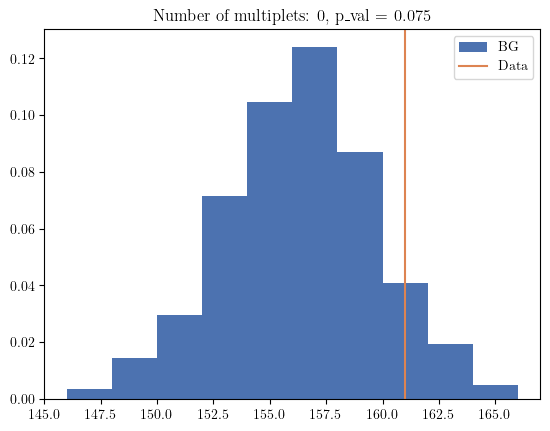

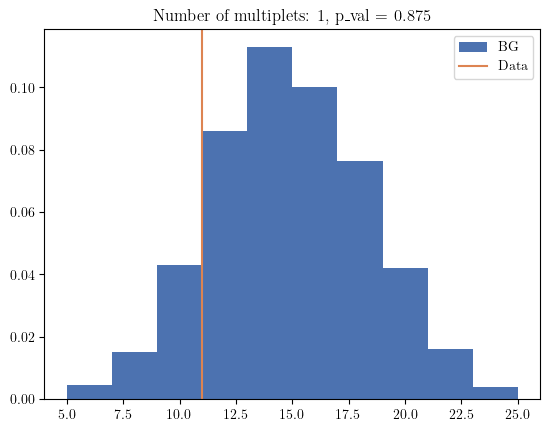

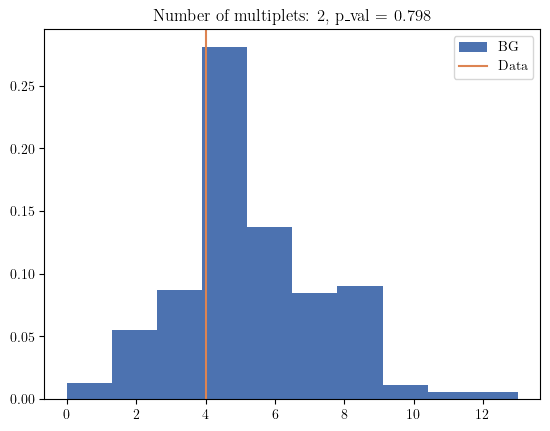

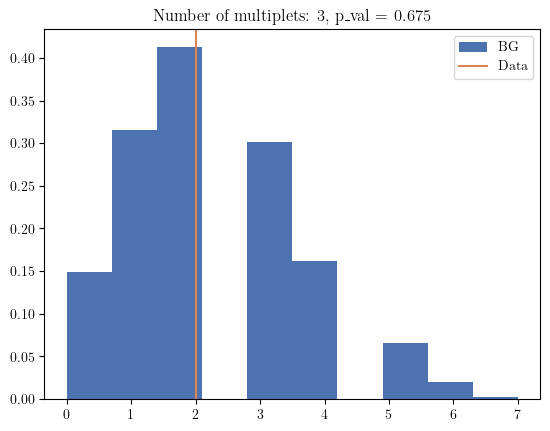

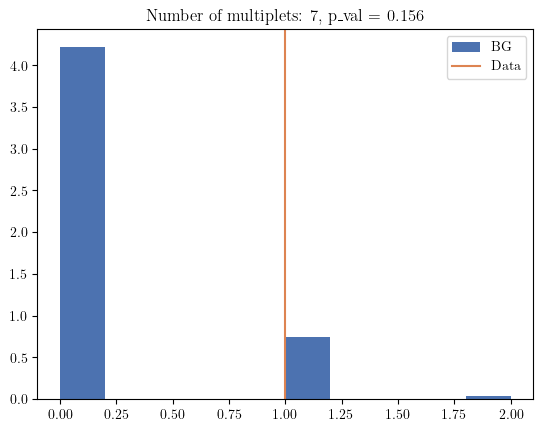

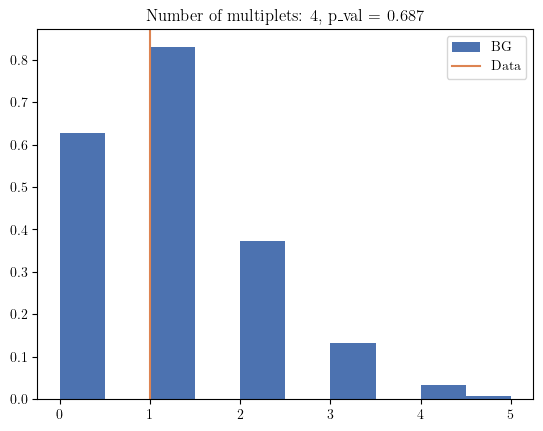

###### Energy threshold  0.504


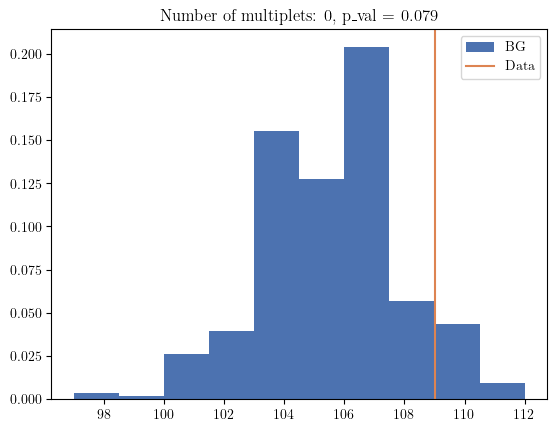

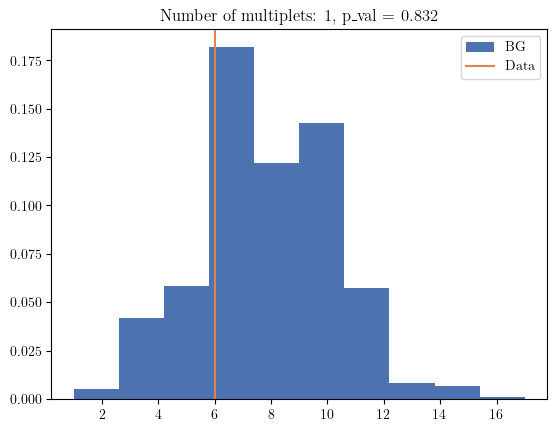

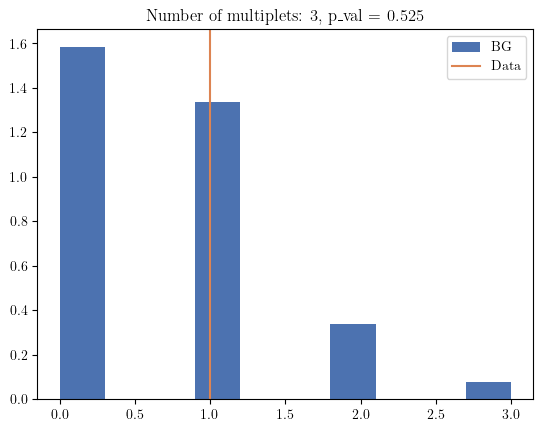

###### Energy threshold  0.45236152112676054


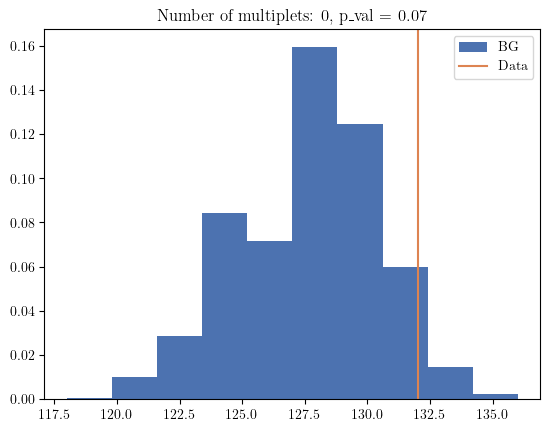

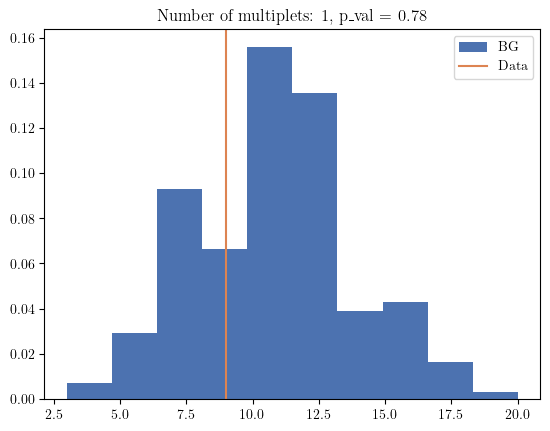

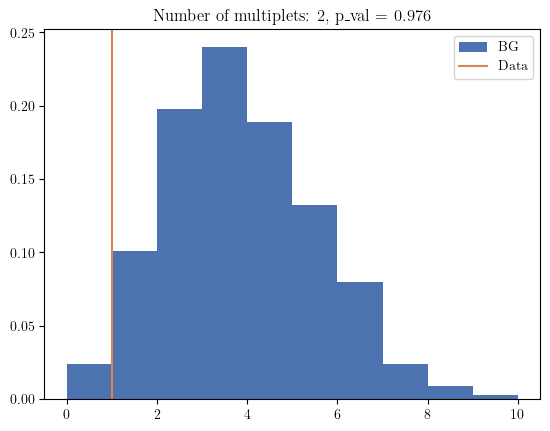

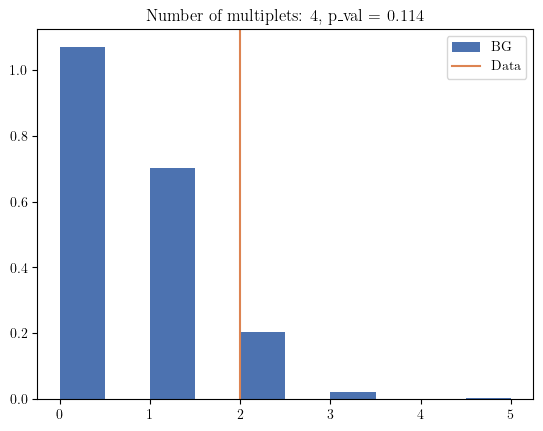

###### Energy threshold  0.5


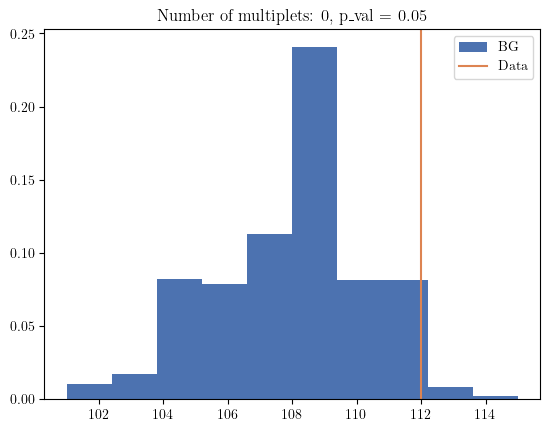

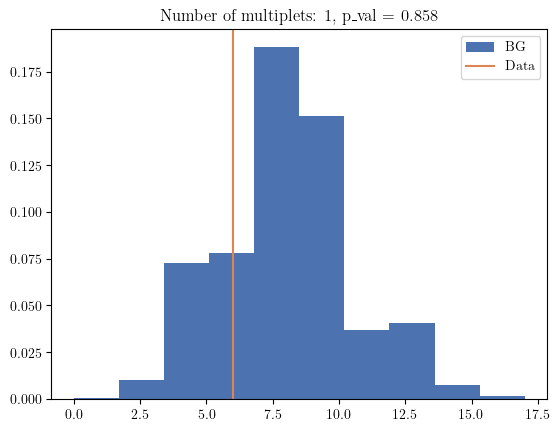

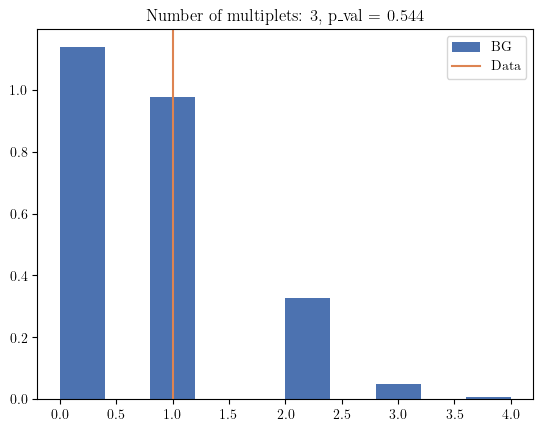

In [8]:
number_multiplets_pval_dict = {}
n_alert_trials = 1000
for my_signalness in bg_multiplets_per_signalness:
    print("###### Signalness threshold ", my_signalness)
    num_mult = []
    p_val = []
    for tmp_key in multiplets_per_energy[my_signalness][0]:
        
        # get "TS distribution", fill the bin with 0 entries
        bin_0 = n_alert_trials - len(bg_multiplets_per_signalness[my_signalness][tmp_key])
        new_arr = np.append(bg_multiplets_per_signalness[my_signalness][tmp_key], [0]*bin_0)
        # get fraction of values larger or equal the data result. This is the p-value
        tmp_p_val = len(new_arr[new_arr >= multiplets_per_signalness[my_signalness][0][tmp_key]]) / len(new_arr)
        plt.title("Number of multiplets: " + str(tmp_key) + ", p_val = " + str(tmp_p_val))
        plt.hist(new_arr, density=True, label="BG", color=dark_colors[0])
        plt.gca().axvline(multiplets_per_signalness[my_signalness][0][tmp_key], label="Data")
        plt.legend()
        plt.show()
        num_mult.append(tmp_key)
        p_val.append(tmp_p_val)
        
    number_multiplets_pval_dict[my_signalness] = [num_mult, p_val]

## Get weighted average circular mean positions

In [11]:
weighted_x, weighted_sigma = go_through_area_multiplet_dict(multiplets_per_signalness, alerts)